In [1]:
import numpy as np
import h5py as h5
import sys
import physical_data as const
from read_parameter_file import read_params
import reading_data_for_los as RD
import matplotlib.pyplot as plt
from computeibb import computeibb as computeib
from prodata import projectdata
from projectdataf import project_data
import time
from intergrid import Intergrid   
from read_ionizationtables import read_iontables
import read_ionizationtables as RIT

/cosma/local/Python/2.7.15/lib/python2.7/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.10.3 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


This is saying the use snapshot file is True


## Extra functions

In [2]:
def los_long_axis(Position,HubbleParam,ExpansionFactor):
    '''
    Returns the long axis that the LOS belongs to
    0-x
    1-y
    2-z
    '''
    return np.argmax([(Position[:,0].max()-Position[:,0].min()) /HubbleParam * ExpansionFactor,(Position[:,1].max()-Position[:,1].min()) /HubbleParam * ExpansionFactor,(Position[:,2].max()-Position[:,2].min()) /HubbleParam * ExpansionFactor])

In [3]:
def align_positions(los_long_axis,Position):
    '''
    Changes the frame of reference of the coordinates, depending on the long axis.
    '''
    Position_2 = np.zeros(np.shape(Position),dtype=np.float128)
    if los_long_axis == 0:
        Position_2[:,0] = Position[:,1]
        Position_2[:,1] = Position[:,2]
        Position_2[:,2] = Position[:,0]
    elif los_long_axis == 1:
        Position_2[:,0] = Position[:,2]
        Position_2[:,1] = Position[:,0]
        Position_2[:,2] = Position[:,1]

    else:
        Position_2[:,0] = Position[:,0]
        Position_2[:,1] = Position[:,1]
        Position_2[:,2] = Position[:,2]
    
    return Position_2

## Main Code

### Loading the parameters

In [5]:
#Load dummy parameters from a "typical" specwizard run 
parameters = read_params('dummy.par')

#Load class that contianes the particle information i,e position, velocities etc.
loss = RD.read_particle_data_from_los(parameters,1)        

#Load the class the contains the header information
simdata = RD.read_header(parameters)

#Conversion factors 
convert = RD.units_and_factors_for_los(parameters)

# This outputs which is what is the long axis from the LOS  (0=x,1=y,z=2)
loss.los_long_axis = los_long_axis(loss.Position, simdata.HubbleParam, simdata.ExpansionFactor)
loss.Position = align_positions(loss.los_long_axis,loss.Position)

LOS1/PartType0/Positions


In [6]:
acurrent = simdata.ExpansionFactor
zcurrent = simdata.Redshift

simdata.CurrentHubbleCt = 100. * simdata.HubbleParam *  np.sqrt(1. + simdata.Omega0*(1./acurrent-1.) + simdata.OmegaLambda* (acurrent**2-1.)) /acurrent
simdata.boxkms = simdata.BoxSize / simdata.HubbleParam * acurrent * simdata.CurrentHubbleCt

simdata.vpixsizekms = 1
simdata.nveloc = int(simdata.boxkms / simdata.vpixsizekms) + 1

In [7]:
Coordinates_conv     = convert.Pos_aexp_exp * np.log10(simdata.ExpansionFactor) + convert.Pos_h_exp * np.log10(simdata.HubbleParam) + np.log10(convert.Pos_cgs_unit) - np.log10(convert.cm_per_mpc) # in physical Mpc
Coordinates_conv     = 10.0**Coordinates_conv
loss.Position = loss.Position * Coordinates_conv
BoxPhys = simdata.BoxSize * Coordinates_conv
loss.ParticleSmoothingLength = loss.ParticleSmoothingLength * Coordinates_conv

In [8]:
Velocity_conv = convert.Vel_aexp_exp * np.log10(simdata.ExpansionFactor) + convert.Vel_h_exp * np.log10(simdata.HubbleParam) + np.log10(convert.Vel_cgs_unit) - np.log10(1e5) #$ physical km/s
Velocity_conv = 10.0**Velocity_conv
loss.Velocity = loss.Velocity * Velocity_conv

In [9]:
Density_conv = convert.Dens_aexp_exp * np.log10(simdata.ExpansionFactor) + convert.Dens_h_exp * np.log10(simdata.HubbleParam) + np.log10(convert.Dens_cgs_unit)- np.log10(convert.proton_mass)
Density_conv = 10**Density_conv

loss.ParticleDensity = loss.ParticleDensity * Density_conv
#Convert from total density to *Hydrogen* number density
loss.ParticleDensity = loss.ParticleDensity * loss.MassFractions[:,0]
loss.Metallicity = loss.Metallicity[...] / const.Zmass_solar  #metallicity in solar units

In [10]:
Mass_conv = convert.Mass_aexp_exp * np.log10(simdata.ExpansionFactor) + convert.Mass_h_exp * np.log10(simdata.HubbleParam) + np.log10(convert.Mass_cgs_unit) - np.log10(convert.solar_mass)
Mass_conv = 10.0**Mass_conv
loss.Mass   = loss.Mass * Mass_conv

In [12]:
Temp_Conv           = convert.Temp_aexp_exp * np.log10(simdata.ExpansionFactor) + convert.Temp_h_exp * np.log10(simdata.HubbleParam) + np.log10(convert.Temp_cgs_unit) #! cgs
Temp_Conv           = 10.0**Temp_Conv
loss.ParticleTemperature = loss.ParticleTemperature * Temp_Conv 

In [13]:
loss.x_physical = loss.x_position * Coordinates_conv  #LOS x-starting point
loss.y_physical = loss.y_position * Coordinates_conv  #LOS y-starting point

In [14]:
#load ionization table parameters
ionpar = RIT.read_iontables(parameters)

h1 Ionization table loaded
n2 Ionization table loaded
n5 Ionization table loaded
ne8 Ionization table loaded
si2 Ionization table loaded


In [15]:
loss,tf = project_data(loss,simdata,parameters,ionpar)

projectdataf.py:49: RuntimeWarning: divide by zero encountered in log10
  ionizbal = np.log10(ionpar.ionss)


It took 5.426018 seconds


In [16]:
hhh = h5.File("/cosma6/data/dp004/dc-aram1/VariableIMF/patchrea/specwizgit/natasha/specwizard_versions/rhotot_los_1.hdf5", 'r')

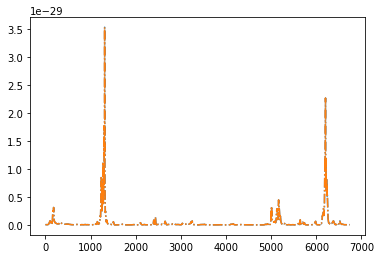

In [21]:
plt.plot(loss.rho_tot*6.76991130339558456e-41,"-.")
plt.plot(hhh['rho_tot($i)'][...],'-.')


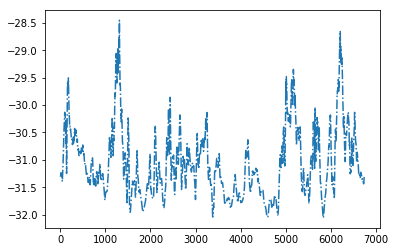

In [18]:
plt.plot(np.log10(loss.rho_tot*6.76991130339558456e-41),"-.")
